# Лабораторная работа №5
Построить бифуркационную диаграмму динамической системы, описываемой неавтономным обыкновенным дифференциальным уравнением:

$
\ddot{x} + 5(x^2-1)\dot{x}+x=5\cos{\omega t}, \ \omega \in [2.4, 2.5]
$

Для нескольких значений параметра из заданного промежутка посчитать спектр показателей Ляпунова аттрактора, соотнести с полученными на диаграмме результатами. Для тех же нескольких аттракторов рассчитать спектр частот и размерность. Размерность посчитать двумя способами: (1) покрытие кубами сечения Пуанкаре, (2) по формуле Каплана-Йорка.

Для начала перепишем ОДУ как систему в каноническом виде:

$
\begin{cases}
    \dot{x} = y \\
    \dot{y} = -5(x^2-1)y - x + 5\cos{z}\\
    \dot{z} = \omega
\end{cases}
$

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

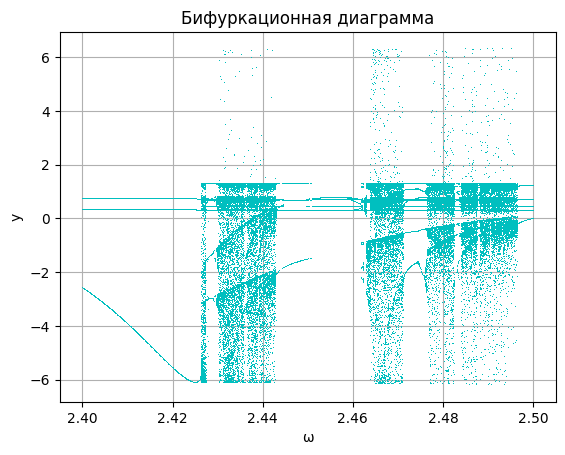

In [4]:
def model(y, t, d, ω, a):
    x, dxdt = y
    return [dxdt, a * np.cos(ω * t) - d*(x**2-1)*dxdt-x]

d = 5
a = 5

ω_range = np.arange(2.4, 2.5, 0.0001)

y0 = [3, 0]

fig, ax = plt.subplots()

for ω in ω_range:
    t = np.arange(0, 1000, 2 * np.pi / ω)
    sol = odeint(model, y0, t, args=(d, ω, a))
    sol = sol[100:]
    ax.plot(ω * np.ones(len(sol)), sol[:, 1], ls= '', marker=',', color='c')

ax.set_xlabel('ω')
ax.set_ylabel('y')
ax.set_title('Бифуркационная диаграмма')
ax.grid(True)

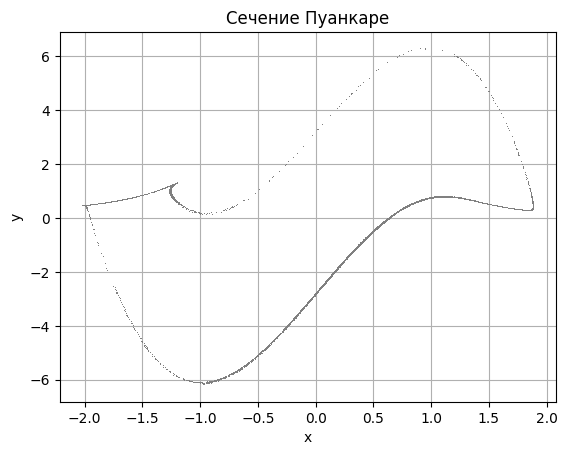

In [8]:
def model(y, t, d, ω, a):
    x, dxdt = y
    return [dxdt, a * np.cos(ω * t) - d*(x**2-1)*dxdt-x]


d = 5
a = 5

ω_range = np.arange(2.4, 2.5, 0.0005)

y0 = [3, 0]

fig, ax = plt.subplots()

for ω in ω_range:
    t = np.arange(0, 1000, 2 * np.pi / ω)
    sol = odeint(model, y0, t, args=(d, ω, a))
    sol = sol[100:]
    ax.plot(sol[:, 0], sol[:, 1], ls='', marker=',', color='grey')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Сечение Пуанкаре')
ax.grid(True)

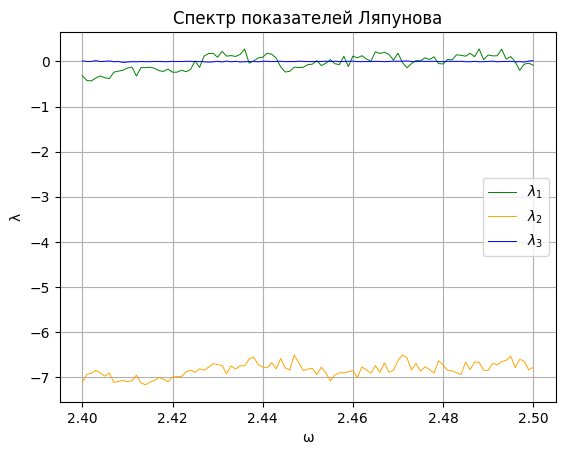

In [10]:

def initial_model(t, g, d, ω, a):
    x, y, z = g

    # исходная система
    dxdt = y
    dydt = a * np.cos(z) - d*(x**2-1)*y-x
    dzdt = ω

    return np.array([dxdt, dydt, dzdt])


def model(t, g, d, ω, a):
    x, y, z, δx1, δy1, δz1, δx2, δy2, δz2, δx3, δy3, δz3 = g

    # исходная система
    dxdt = y
    dydt = a * np.cos(z) - d*(x**2-1)*y-x
    dzdt = ω
    # уравнения в вариациях
    δx1δt = δy1
    δy1δt =  (-2*d*y*x-1)*δx1 -d*(x**2-1)* δy1 - a*np.sin(z)*δz1
    δz1δt = 0
    δx2δt = δy2
    δy2δt = (-2*d*y*x-1)*δx2 -d*(x**2-1)* δy2 - a*np.sin(z)*δz2
    δz2δt = 0
    δx3δt = δy3
    δy3δt = (-2*d*y*x-1)*δx3 -d*(x**2-1)* δy3 - a*np.sin(z)*δz3
    δz3δt = 0

    # Return a NumPy array with a shape of (12,)
    return np.array([dxdt, dydt, dzdt, δx1δt, δy1δt, δz1δt, δx2δt, δy2δt, δz2δt, δx3δt, δy3δt, δz3δt])

def Gram_Schmidt_orthogonalization(with_wave):
    # список для хранения ортогональных векторов
    ortho_vectors = []

    # ортогонализация каждого вектора относительно предыдущих
    for vector in with_wave:

        ortho_vector = vector.copy()

        for ortho_vec in ortho_vectors:
            ortho_vector -= np.dot(ortho_vector, ortho_vec) / (np.dot(ortho_vec, ortho_vec) + epsilon) * ortho_vec

        ortho_vectors.append(ortho_vector)

    return ortho_vectors

d = 5
a = 5
ω_range = np.arange(2.4, 2.5, 0.001)

ω_values = []
s0_values = []
s1_values = []
s2_values = []

M = 100
epsilon = 1e-10
T = 1
t_span = (0, T)

for ω in ω_range:

    s = [[0] for i in range(3)]

    sol = solve_ivp(initial_model, (0, 1000), [3, 0, 0], t_eval=np.arange(0, 1000, 2 * np.pi / ω), args=(d, ω, a))
    g0 = [sol.y[0, -1], sol.y[1, -1], sol.y[2, -1], 1, 0, 0, 0, 1, 0, 0, 0, 1]

    for i in range(M):
        sol = solve_ivp(model, t_span, g0, t_eval=np.linspace(*t_span, 1000), args=(d, ω, a))
        g0 = sol.y[:, -1]

        with_wave = Gram_Schmidt_orthogonalization([g0[3:6], g0[6:9], g0[9:12]])

        for i in range(3):
            s[i].append(np.log(np.dot(with_wave[i], with_wave[i]) + epsilon) + s[i][-1])
            with_wave[i] /= (np.dot(with_wave[i], with_wave[i]) + epsilon)  # нормируем

        # обновляем g0
        g0[3:6] = with_wave[0]
        g0[6:9] = with_wave[1]
        g0[9:12] = with_wave[2]

    ω_values.append(ω)
    s0_values.append(s[0][-1] / M * T)
    s1_values.append(s[1][-1] / M * T)
    s2_values.append(s[2][-1] / M * T)

plt.plot(ω_values, s0_values, '-', lw=0.7, label=r'$\lambda_1$', markersize=1, color='green')
plt.plot(ω_values, s1_values, '-', lw=0.7, label=r'$\lambda_2$', markersize=1, color='orange')
plt.plot(ω_values, s2_values, '-', lw=0.7, label=r'$\lambda_3$', markersize=1, color='blue')
plt.grid(True)
plt.title('Спектр показателей Ляпунова')

plt.xlabel('ω')
plt.ylabel('λ')
plt.legend()
plt.show()




In [11]:

λ1 = s0_values[35]
λ2 = s1_values[35]
λ3 = s2_values[35]
print('По формуле Каплана-Йорка размерность',1 + (λ1 + λ3) / np.abs(λ2))

По формуле Каплана-Йорка размерность 1.0213276716181001


Размерность через покрытие кубами сечения Пуанкаре 1.0736269005784864


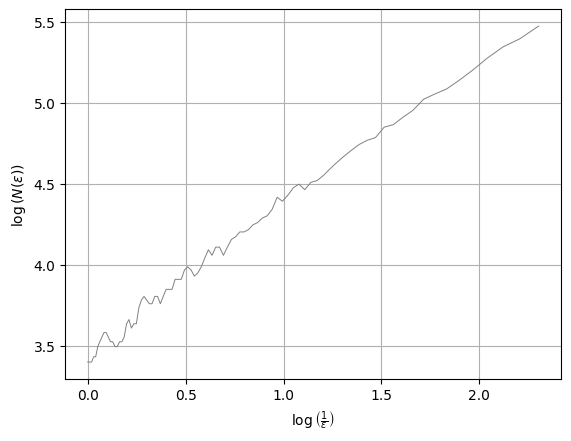

In [23]:
def model(y, t, d, ω, a):
    x, dxdt = y
    return [dxdt, a * np.cos(ω * t) - d*(x**2-1)*dxdt-x]


d = 5
a = 5
ω = 2.435

y0 = [3, 0]

fig, ax = plt.subplots()
t = np.arange(0, 100000, 2 * np.pi / ω)
sol = odeint(model, y0, t, args=(d, ω, a))
sol = sol[100:]

x_values, y_values = sol[:, 0], sol[:, 1]
min_x, max_x = np.min(x_values), np.max(x_values)
min_y, max_y = np.min(y_values), np.max(y_values)


epsilon_range = np.arange(0.1, 1.01, 0.01)
amount_of_cubes = np.zeros(len(epsilon_range))

for i, epsilon in enumerate(epsilon_range):
    num_cubes_x = int((max_x - min_x) / epsilon) + 1
    num_cubes_y = int((max_y - min_y) / epsilon) + 1
    num_cubes = num_cubes_x * num_cubes_y

    for j in range(num_cubes_x):
        for k in range(num_cubes_y):
            x_min = min_x + j * epsilon
            x_max = x_min + epsilon
            y_min = min_y + k * epsilon
            y_max = y_min + epsilon
            if np.any((x_values >= x_min) & (x_values < x_max) & (y_values >= y_min) & (y_values < y_max)):
                amount_of_cubes[i] += 1


plt.plot(np.log(1 / epsilon_range), np.log(amount_of_cubes), '-', color='grey', lw=0.7)
plt.xlabel('$\\log\\left(\\frac{1}{\\epsilon}\\right)$')
plt.grid(True)
ax.set_ylabel('$\\log\\left(N(\\epsilon)\\right)$')

print('Размерность через покрытие кубами сечения Пуанкаре',np.abs(np.log(amount_of_cubes)[-1] - np.log(amount_of_cubes)[45]) / np.abs(np.log(1 / epsilon_range)[-1] - np.log(1 / epsilon_range)[45]))